#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 9 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2024

You are required to submit your mini-projects by midnight on 07/05/24. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [18]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

In [19]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as op
import pandas as pd
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=db8fce2c-c680-47f5-94c0-2d7b376d6f25
To: c:\Users\sande\OneDrive\Bureau\EPFL\MA4\Brain-Like\NX-414\Project\IT_data.h5
100%|██████████| 384M/384M [00:24<00:00, 15.4MB/s] 


'IT_data.h5'

In [20]:
try:
    %pip install torchinfo
except:
    print("Couldn't install torchinfo")

Note: you may need to restart the kernel to use updated packages.


In [39]:
# Extra imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchinfo import summary
from torchvision.models import densenet169, DenseNet169_Weights
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import RidgeCV, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the data

In [22]:
path_to_data = "" ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


# Challenge: Develop the best model to predict the IT neural activity

Throughout the mini-projects, you've gained experience in predicting neural activity using both task-driven and data-driven approaches. Now, you are free to explore and to leverage your knowledge and creativity to develop a model that predicts neural activity with the highest accuracy possible. You can achieve this through various strategies.

Some suggestions:
- Optimize the models you have already developed: hyperparameters and regularization
- Use different pretrained models
- Use a pretrained neural network and finetune it to predict the neural activity
- Cotrain a neural network to perform object recognition and to predict the neural activity at the same time
- ...

Note that we will use the same linear regression for testing all your models.

In this final part of our project, we will have a look at deepnet-169, another deep net which we have seen in the course. Notably, we saw that it had both a relatively good brain and image classification score.

![title](img/CourseImg.png)

We will use a pipeline similar to the one used in part 1. First, we define the required helper functions.

In [23]:
# Variable to see if we import the PCs or if we run the extraction
importPCs = True

# Function to extract and return the activations of some layer of interest
# This function is actually somewhat of a modified forward function that just gets what we need.
def layerActivationExtractor(model, input, layer_name):
    """
    Arguments :
    - model : the densenet-169 model
    - input : the images, of size N_images x H x W
    - layer_name : the name of the layer of interest
    
    Output : activations, ndarray of size N_images x (shape_activations)
    
    Description :
    This function gets the activations for all images for one layer of interest.
    It sequentially passes the input through the layers manually, stopping after the layer of interest to return the activations.
    In order, and thanks to the summary in the previous cell, we know that the input passes through the layers... 
    - conv0
    - norm0
    - relu0
    - pool0
    - denseblock1
    - transition1
    - denseblock2
    - transition2
    - denseblock3
    - transition3
    - denseblock4
    - norm5
    - classifier
    """
    if layer_name not in ["conv0", "transition1", "transition2", "transition3", "norm5"]:
        raise ValueError("Non-compatible layer name.")
    
    all_activations = np.repeat(None, input.shape[0])
    for i in range(input.shape[0]):
        # Resize each to the appropriate size of 1 x 3 x 224 x 224
        model_input = input[i].unsqueeze(0)
        # Pass through conv1
        activation = model.conv0(model_input)
        # This is a layer of interest, let's grab the activations
        if layer_name == "conv0":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()
            continue

        # Pass through norm0
        activation = model.norm0(activation)
        # Pass through relu0
        activation = model.relu0(activation)
        # Pass through pool0
        activation = model.pool0(activation)

        # Pass through denseblock1
        activation = model.denseblock1(activation)
        # Pass through transition1
        activation = model.transition1(activation)
        # This is a layer of interest, let's grab the activations
        if layer_name == "transition1":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()

        # Pass through denseblock2
        activation = model.denseblock2(activation)
        # Pass through transition2
        activation = model.transition2(activation)
        # This is a layer of interest, let's grab the activations
        if layer_name == "transition2":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()

        # Pass through denseblock3
        activation = model.denseblock3(activation)
        # Pass through transition3
        activation = model.transition3(activation)
        # This is a layer of interest, let's grab the activations
        if layer_name == "transition3":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()

        # Pass through denseblock4
        activation = model.denseblock4(activation)
        # Pass through norm5
        activation = model.norm5(activation)
        # This is a layer of interest, let's grab the activations
        if layer_name == "norm5":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()
    
    # We don't care about the model's actual output, so we don't pass through the final layer.

    return np.stack(all_activations)

# Now, let's make a function to run a PCA and extract the PCs on the extracted activations
def extractPCs(activations_train, activations_val):
    """
    Arguments :
    - activations_train : the train activations array, of size N_images x N_activations
    - activations_val : the validation activations array, of size N_images x N_activations
    
    Output : PCs for the activations tensor, ndarray of size N_images x N_PCs
    
    Description :
    This function extracts the PCs from the activations tensor for both train and test set. 
    We need this to be done together as we want the PCA to be fit on the entire dataset (train + validation)'s activations, 
    not have separate PCAs for train and validation sets. 
    """
    
    # Run a PCA and get the PCs
    n_PCs = 1000
    pca = PCA(n_components = n_PCs)
    pca = pca.fit(np.concatenate((activations_train, activations_val), axis = 0))
    pcs_train = pca.transform(activations_train)
    pcs_val = pca.transform(activations_val)
    
    return [pcs_train, pcs_val]

# Let's make a function that saves the PCs in a CSV file
def savePCs(pcs, filename, pc_folder_path):
    """
    Arguments :
    - pcs : the principle components array, of size N_images x N_PCs
    - filename : the name given to the file we want to save to
    - pc_folder_path : path to the folder what will contain all of the PCs
    
    Output : None
    
    Description :
    This function saves the PCs of some layer into a CSV file.
    The goal of this is to not have to run the activation extraction procedure multiple times, rather only once.
    """
    
    # Define path to csv file
    csv_file_path = pc_folder_path + filename + ".csv"
    
    # Create the csv file for storing the PCs if it doesn't exist yet
    if not os.path.exists(csv_file_path):
        with open(csv_file_path, "w"):
            pass  # This will create an empty file
    
    # Write the activations in
    df = pd.DataFrame(pcs)
    df.to_csv(csv_file_path, index = False, header = False)
    
# Let's make a function that loads the PCs from the csv file
def loadPCs(filename, pc_folder_path):
    """
    Arguments : 
    - filename : the name of the file we want to load the activations from, without .csv extension
    - pc_folder_path : path to the folder what contains all of the PCs
    
    Output : PCs for the layer, ndarray of size N_images x N_PCs
    """
    
    # Define path to csv file
    csv_file_path = pc_folder_path + filename + ".csv"
    
    # Load csv file to a pandas dataframe
    df = pd.read_csv(csv_file_path, header = None)
    
    return df.to_numpy()

# Define the two evaluation metrics
## Pearson correlation
def pearson_correlation(y_true, y_pred):
      n_neurons = y_true.shape[1]
      corrs = np.zeros(n_neurons)
      for i in range(n_neurons):
            corrs[i] = pearsonr(y_true[:, i], y_pred[:, i])[0]
      return corrs

## Explained variance
def R_squared(y_true, y_pred):
      n_neurons = y_true.shape[1]
      Rs_squared = np.zeros(n_neurons)
      for i in range(n_neurons):
            Rs_squared[i] = r2_score(y_true[:, i], y_pred[:, i])
      return Rs_squared

# Helper functions for running regressions and plotting of metrics
def fitRegressions(X_train, y_train):
    # Define all models
    lsq = LinearRegression()
    ridge = Ridge(alpha=10, solver='svd')
    lasso = Lasso(alpha=0.1)
    elastic = ElasticNet(alpha=1.0, l1_ratio=0.5)
    # Fit all models
    lsq.fit(X_train, y_train)
    ridge.fit(X_train, y_train)
    lasso.fit(X_train, y_train)
    elastic.fit(X_train, y_train)
    
    return [lsq, ridge, lasso, elastic]

def runRegressions(X_train, y_train, X_val, y_val):
    # Fit all regressions
    models = fitRegressions(X_train, y_train)
    corrs = []
    explVars = []
    for model in models:
        # Make prediction
        y_pred = model.predict(X_val)
        # Compute correlation and explained variance
        corr = pearson_correlation(y_val, y_pred)
        explVar = R_squared(y_val, y_pred)
        # Append to lists
        corrs.append(corr)
        explVars.append(explVar)
    
    return [corrs, explVars]

def plotResults(all_results, method_names, metric_names):
    plt.figure()
    for i in range(2):
        for j in range(4):
            plt.subplot(2,4,4*i+j+1)
            plt.plot(all_results[i][j])
            if i==0:
                plt.title(method_names[j])
            if i==1:
                plt.xlabel('Neuron index')
            if j==0:
                plt.ylabel(metric_names[i])


In [13]:
# Loading the pretrained ResNet50 model
weights = DenseNet169_Weights.DEFAULT
model = densenet169(weights = weights, progress = True).to(device)

# As we won't be training the model (it's already pretrained, we just want the activations in the intermediate layers) we can set require_grad to False for all params.
for param in model.parameters():
    param.require_grad = False

# Get a summary of the model
summary(model = model, 
        input_size = [1, 3, 224, 224], 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to C:\Users\sande/.cache\torch\hub\checkpoints\densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:02<00:00, 19.8MB/s]


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                       [1, 3, 224, 224]     [1, 1664, 7, 7]      --                   True
│    └─Conv2d (conv0)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
│    └─BatchNorm2d (norm0)                    [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
│    └─ReLU (relu0)                           [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─MaxPool2d (pool0)                      [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
│    └─_DenseBlock (denseblock1)              [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    │    └─_DenseLayer (denselayer1)         [1, 64, 56, 56]      [1, 32, 56, 56]     

Now, we extract activations and their PCA components from the deepnet-169 model.

In [15]:
# Convert stimulus to torch tensor
stimulus_train = torch.from_numpy(stimulus_train).to(device)
stimulus_train.require_grad = False

stimulus_val = torch.from_numpy(stimulus_val).to(device)
stimulus_val.require_grad = False

In [16]:
# Make results folder
pc_folder_path = "results_pt3/"
os.makedirs(pc_folder_path, exist_ok=True)

In [17]:
if not importPCs:
    # Extract PCs from activations and save them
    for layer_name in ["conv1", "layer1", "layer2", "layer3", "layer4", "avgpool"]:
        # Get activations
        activations_train = layerActivationExtractor(model, stimulus_train, layer_name) 
        activations_val = layerActivationExtractor(model, stimulus_val, layer_name) 
        # Get PCs
        pcs_train, pcs_val = extractPCs(activations_train, activations_val)
        savePCs(pcs_train, layer_name+"_train", pc_folder_path)
        savePCs(pcs_val, layer_name+"_val", pc_folder_path)
        print(f"Extraction and saving for layer {layer_name} done!")

Next we use the PCs to compute the neural activity.

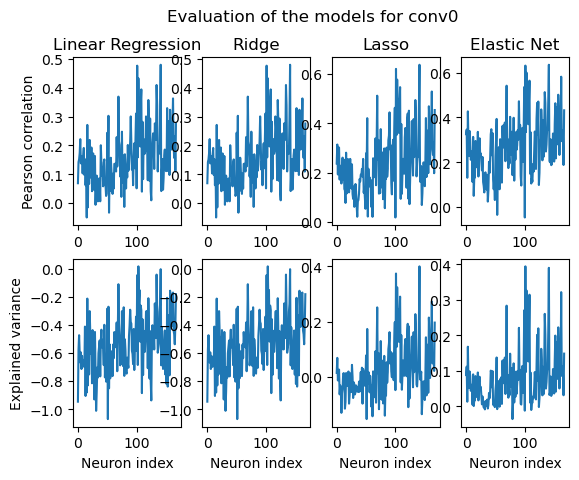

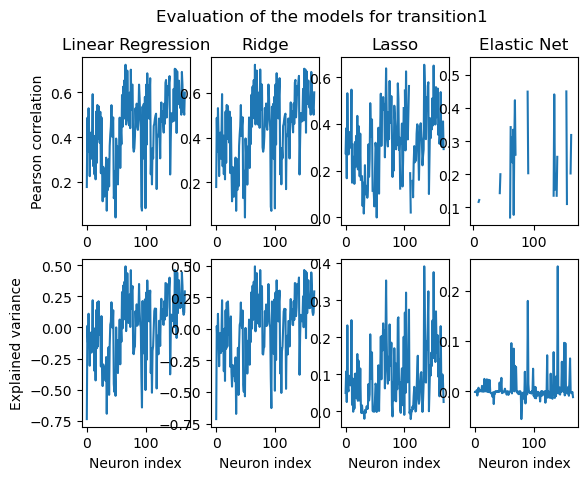

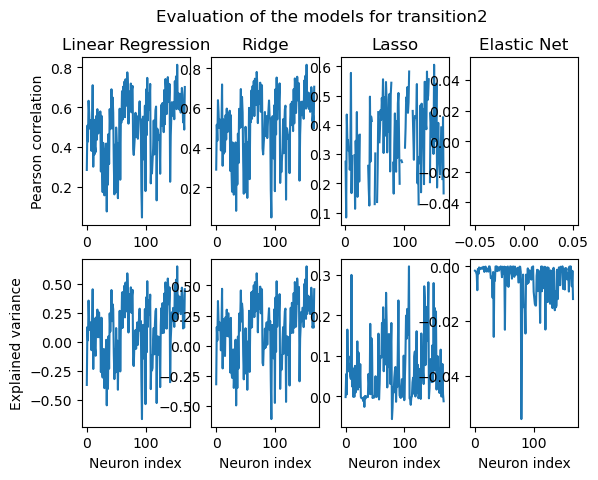

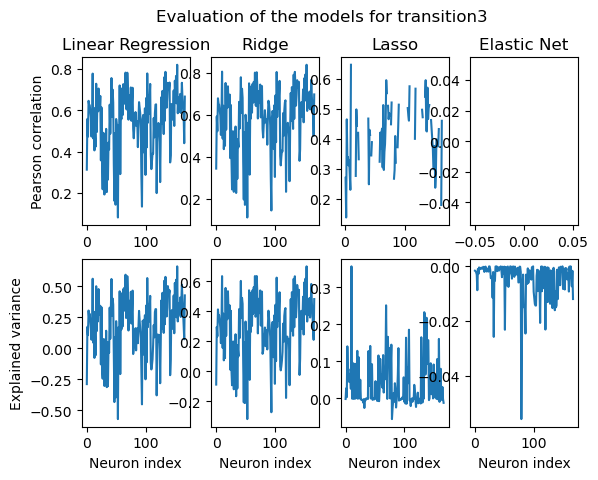

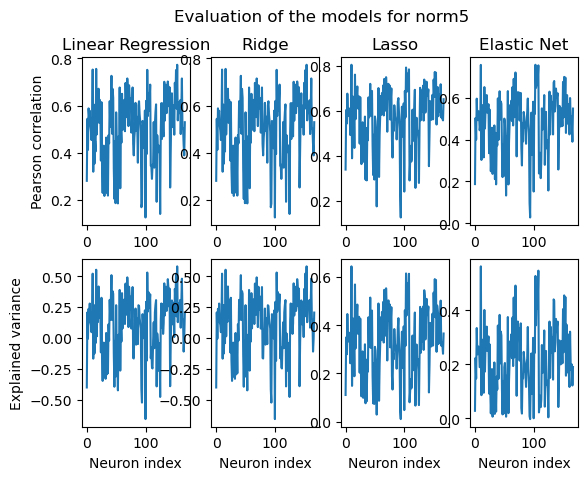

In [24]:
method_names = ["Linear Regression", "Ridge", "Lasso", "Elastic Net"]
metric_names = ["Pearson correlation", "Explained variance"]

all_results = []
for layer_name in ["conv0", "transition1", "transition2", "transition3", "norm5"]:
    # Load the PCs
    PCs_train = loadPCs(layer_name+"_train", pc_folder_path)
    PCs_val = loadPCs(layer_name+"_val", pc_folder_path)
    # Run regressions and get metrics for each
    results = runRegressions(PCs_train, spikes_train, PCs_val, spikes_val)
    all_results.append(results)
    # Plot the results across cells
    plotResults(results, method_names, metric_names)
    plt.suptitle(f'Evaluation of the models for {layer_name}')

plt.show()

Finally, we evaluate the predictions and plot them.

In [26]:
# Create pandas dataframe for each layer, containing minimum, maximum, mean and standard deviation of the metrics
df = pd.DataFrame(columns = ['Layer', 'Method', 'Metric', 'Minimum', 'Maximum', 'Mean', 'Standard deviation'])
for i, layer_name in enumerate(["conv0", "transition1", "transition2", "transition3", "norm5"]):
    for j, method in enumerate(method_names):
        for k, metric in enumerate(metric_names):
            # Get the metric values
            metric_values = all_results[i][k][j]
            # Compute the statistics
            minimum = np.round(np.min(metric_values), 3)
            maximum = np.round(np.max(metric_values), 3)
            mean = np.round(np.mean(metric_values), 3)
            std = np.round(np.std(metric_values), 3)
            # Append to the dataframe
            df = pd.concat([df, pd.DataFrame([{'Layer': layer_name, 'Method': method, 'Metric': metric, 'Minimum': minimum, 'Maximum': maximum, 'Mean': mean, 'Standard deviation': std}])], ignore_index=True)

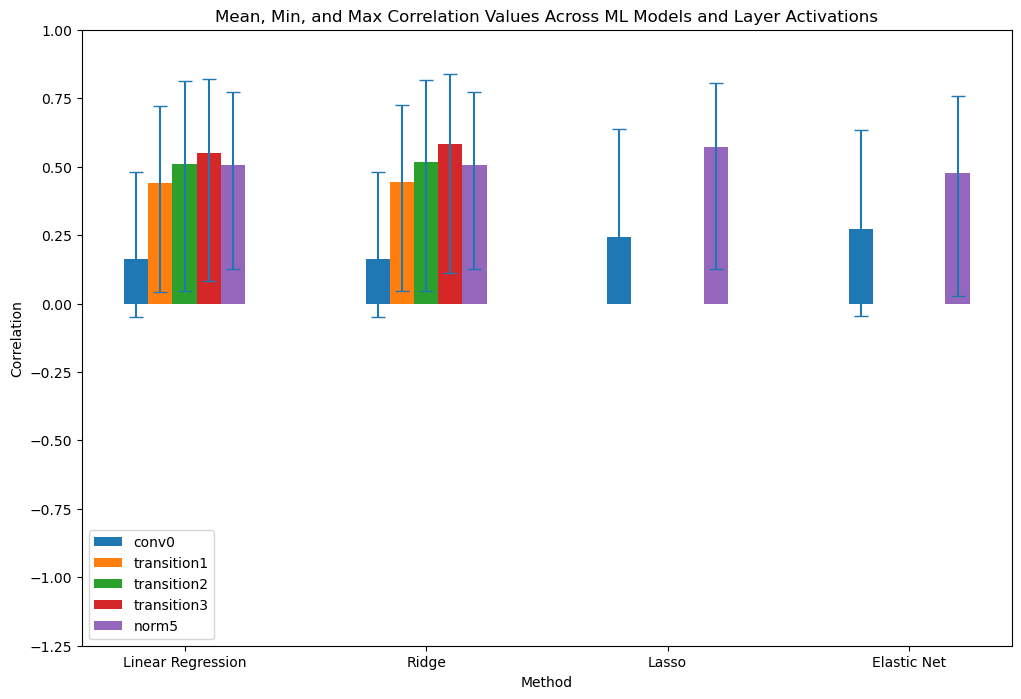

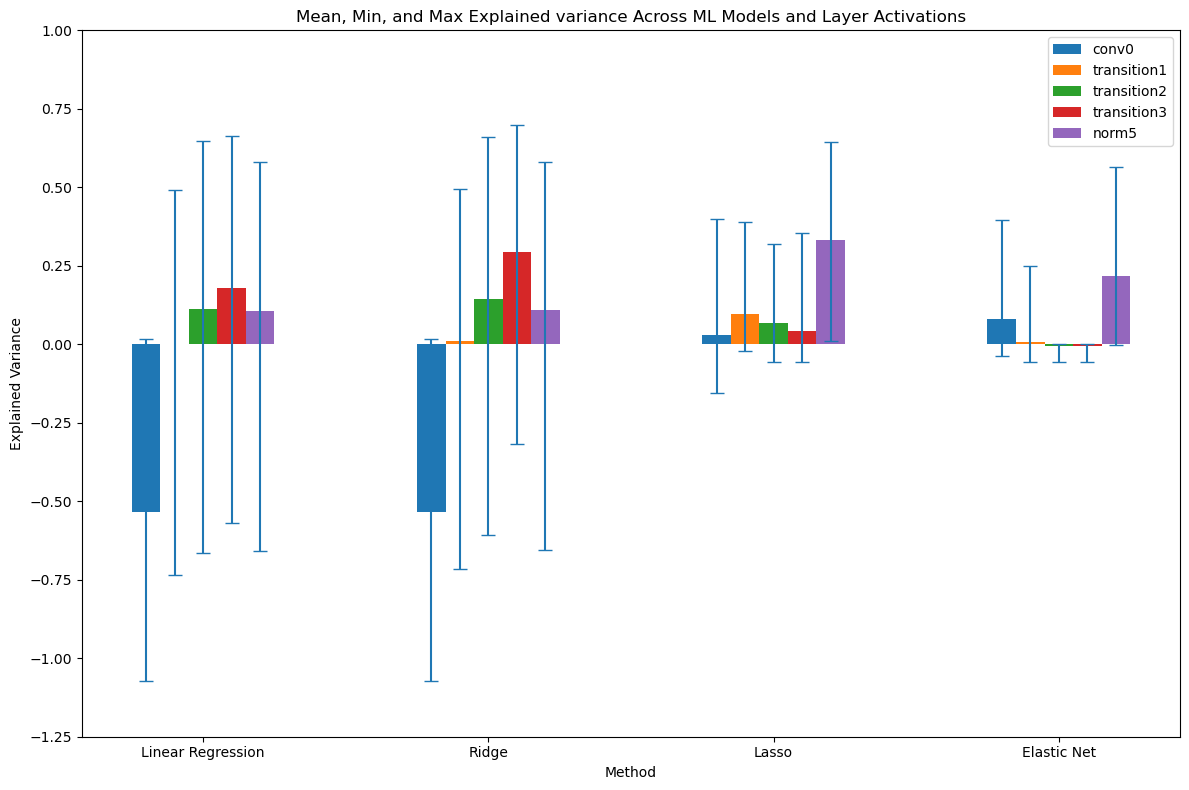

In [27]:
# Get the two dataframes separately
df_corr = df[df['Metric'] == 'Pearson correlation']
df_explVar = df[df['Metric'] == 'Explained variance']

# Get unique layers and methods
layers = df_explVar['Layer'].unique()
methods = df_explVar['Method'].unique()

# Correlation
# Define the figure and axis objects
plt.figure(figsize=(12, 8))

# Plot each combination of method and layer
bar_width = 0.1
index = np.arange(len(methods))

for i, layer in enumerate(layers):
    mean_values = df_corr[df_corr['Layer'] == layer]['Mean']
    min_values = df_corr[df_corr['Layer'] == layer]['Minimum']
    max_values = df_corr[df_corr['Layer'] == layer]['Maximum']
    
    plt.bar(index + i * bar_width, mean_values, bar_width, label=layer)
    plt.errorbar(index + i * bar_width, mean_values, yerr=[mean_values - min_values, max_values - mean_values],
                 fmt='none', capsize=5)

# Add ax limits, labels and title
plt.ylim(-1.25, 1)
plt.xlabel('Method')
plt.ylabel('Correlation')
plt.title('Mean, Min, and Max Correlation Values Across ML Models and Layer Activations')
plt.xticks(index + bar_width * (len(layers) - 1) / 2, methods)
plt.legend()

# Define the figure and axis objects
plt.figure(figsize=(12, 8))

# Plot each combination of method and layer
bar_width = 0.1
index = np.arange(len(methods))

for i, layer in enumerate(layers):
    mean_values = df_explVar[df_explVar['Layer'] == layer]['Mean']
    min_values = df_explVar[df_explVar['Layer'] == layer]['Minimum']
    max_values = df_explVar[df_explVar['Layer'] == layer]['Maximum']
    
    plt.bar(index + i * bar_width, mean_values, bar_width, label=layer)
    plt.errorbar(index + i * bar_width, mean_values, yerr=[mean_values - min_values, max_values - mean_values],
                 fmt='none', capsize=5)

# Add ax limits, labels and title
plt.ylim(-1.25, 1)
plt.xlabel('Method')
plt.ylabel('Explained Variance')
plt.title('Mean, Min, and Max Explained variance Across ML Models and Layer Activations')
plt.xticks(index + bar_width * (len(layers) - 1) / 2, methods)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

Results still aren't great. Let's see if by tuning the hyperparameters of the ridge regression model we can get better results.

In [31]:
# Primary course-grained evaluation of the best alpha
all_alphas = []
for layer_name in ["conv0", "transition1", "transition2", "transition3", "norm5"]:
    # Load the PCs
    PCs_train = loadPCs(layer_name+"_train", pc_folder_path)
    PCs_val = loadPCs(layer_name+"_val", pc_folder_path)
    ## Create the stratified k-fold object
    n_folds = 5
    skf = StratifiedKFold(n_folds, shuffle=True, random_state=42)
    ## Create folds' indexes
    train_idxs = np.repeat(None, n_folds)
    val_idxs = np.repeat(None, n_folds)
    for i, (train_idx, val_idx) in enumerate(skf.split(PCs_train, objects_train)):
        train_idxs[i] = train_idx
        val_idxs[i] = val_idx
    # Getting an approximation of the best alpha
    ## Create the cross validation object 
    ridge_cv = RidgeCV(alphas=np.logspace(0, 9, 10), cv = [(train_idxs[k], val_idxs[k]) for k in range(n_folds)])
    ## Fit the model
    ridge_cv.fit(PCs_train,spikes_train)
    ## See the best alpha
    print(f'The best alpha for {layer_name} is {ridge_cv.alpha_}')
    all_alphas.append(ridge_cv.alpha_)


The best alpha for conv0 is 10000000.0
The best alpha for transition1 is 1000.0
The best alpha for transition2 is 1000.0
The best alpha for transition3 is 100.0
The best alpha for norm5 is 100000.0


In [32]:
# Secondary fine-grained evaluation of the best alpha
best_alphas = []
for i, layer_name in enumerate(["conv0", "transition1", "transition2", "transition3", "norm5"]):
    # Load the PCs
    PCs_train = loadPCs(layer_name+"_train", pc_folder_path)
    PCs_val = loadPCs(layer_name+"_val", pc_folder_path)
    ## Create the stratified k-fold object
    n_folds = 5
    skf = StratifiedKFold(n_folds, shuffle=True, random_state=42)
    ## Create folds' indexes
    train_idxs = np.repeat(None, n_folds)
    val_idxs = np.repeat(None, n_folds)
    for j, (train_idx, val_idx) in enumerate(skf.split(PCs_train, objects_train)):
        train_idxs[j] = train_idx
        val_idxs[j] = val_idx
    # More fine-grained approximation
    ## Create the cross validation object 
    ridge_cv = RidgeCV(alphas=np.linspace(all_alphas[i]/10, all_alphas[i]*10, 11), cv = [(train_idxs[k], val_idxs[k]) for k in range(n_folds)])
    ## Fit the model
    ridge_cv.fit(PCs_train,spikes_train)
    ## See the best alpha
    print(f'The best alpha for {layer_name} is {ridge_cv.alpha_}')
    best_alphas.append(ridge_cv.alpha_)


The best alpha for conv0 is 10900000.0
The best alpha for transition1 is 2080.0
The best alpha for transition2 is 1090.0
The best alpha for transition3 is 109.0
The best alpha for norm5 is 109000.0


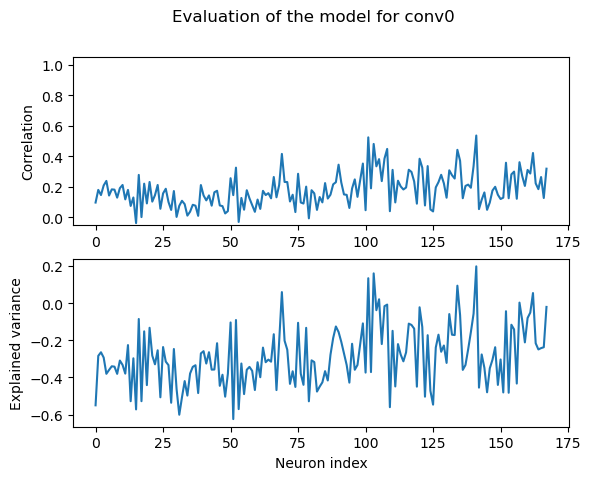

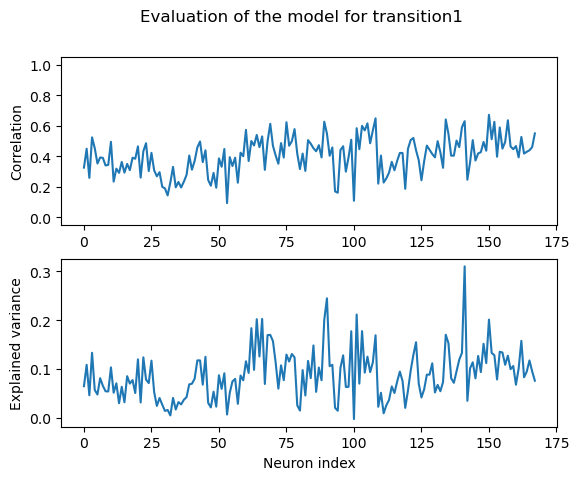

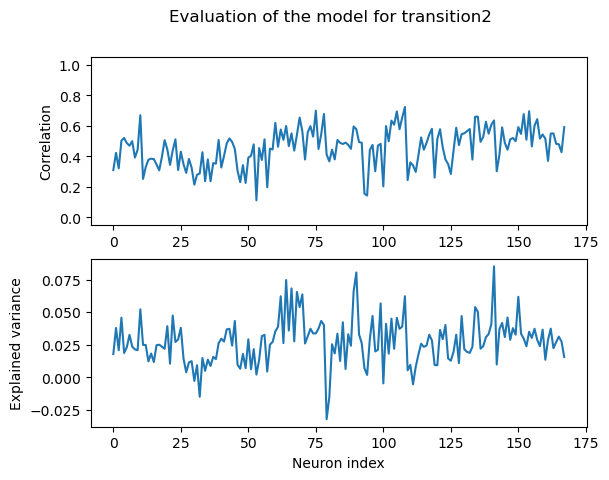

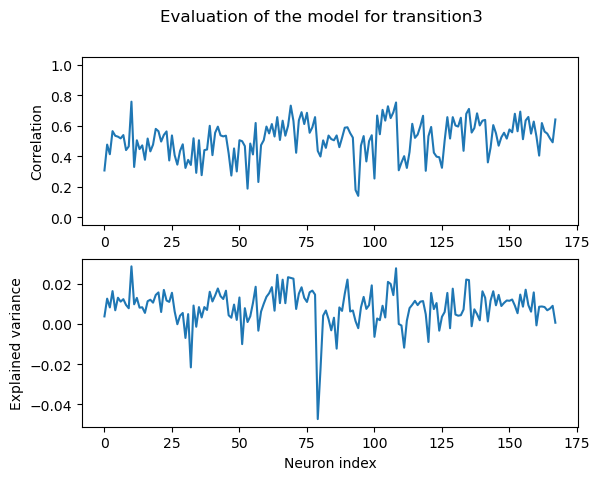

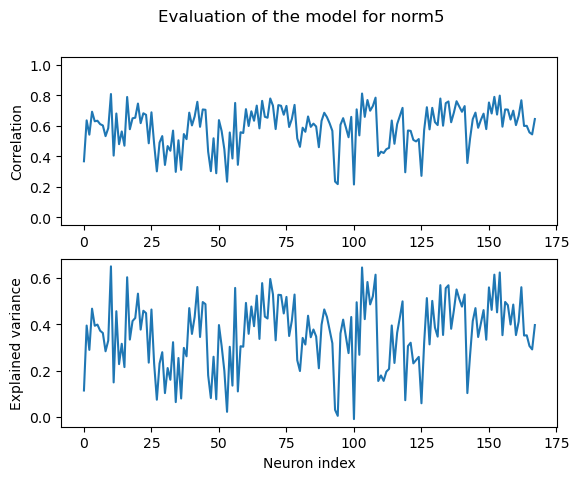

In [68]:
# Now, see the performances for each layer !
all_Rs = []
all_corrs = []
for i, layer_name in enumerate(["conv0", "transition1", "transition2", "transition3", "norm5"]):
      # Load the PCs
      PCs_train = loadPCs(layer_name+"_train", pc_folder_path)
      PCs_val = loadPCs(layer_name+"_val", pc_folder_path)
      ## Create the model
      ridge_final = Ridge(alpha=ridge_cv.alpha_, solver='svd')

      ## Fit the model
      ridge_final.fit(PCs_train,spikes_train)

      ## Get the predictions for the validation set
      y_pred_final = ridge_final.predict(PCs_val)

      ## Evaluate the model
      corrs_final = pearson_correlation(spikes_val,y_pred_final)
      Rs_final = R_squared(spikes_val,y_pred_final)

      all_Rs.append(Rs_final)
      all_corrs.append(corrs_final)

      ## Plot the results
      plt.figure()
      plt.subplot(2,1,1)
      plt.plot(corrs_final)
      plt.ylim([-0.05,1.05])
      plt.ylabel('Correlation')
      plt.subplot(2,1,2)
      plt.plot(Rs_final)
      plt.xlabel('Neuron index')
      plt.ylabel('Explained variance')
      plt.suptitle(f'Evaluation of the model for {layer_name}')
      plt.show()

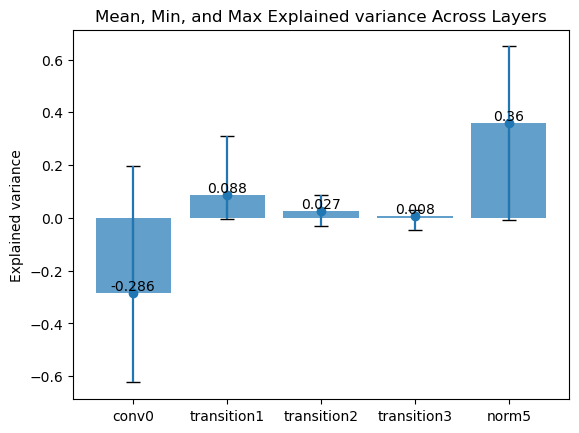

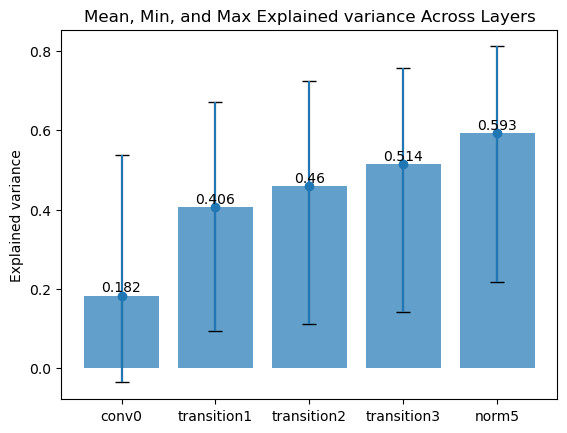

In [69]:
plt.figure()
# Compute mean, min, and max for each array
means = np.array([np.mean(arr) for arr in all_Rs])
mins = np.array([np.min(arr) for arr in all_Rs])
maxs = np.array([np.max(arr) for arr in all_Rs])

# Plot means
plt.bar(range(len(all_Rs)), means, yerr=[means - mins, maxs - means], capsize=5, align='center', alpha=0.7)

# Add error bars for min and max
plt.errorbar(range(len(all_Rs)), means, yerr=[means - mins, maxs - means], fmt='o')
# Add the mean values just above the bars
for i, arr in enumerate(all_Rs):
      plt.text(i, np.mean(arr) + 0.01, s = np.round(np.mean(arr),3),ha='center')
# Rename the xticks
plt.xticks(range(len(all_Rs)), ["conv0", "transition1", "transition2", "transition3", "norm5"])

# Add labels and title
plt.ylabel('Explained variance')
plt.title('Mean, Min, and Max Explained variance Across Layers')

plt.figure()
# Compute mean, min, and max for each array
means = np.array([np.mean(arr) for arr in all_corrs])
mins = np.array([np.min(arr) for arr in all_corrs])
maxs = np.array([np.max(arr) for arr in all_corrs])

# Plot means
plt.bar(range(len(all_corrs)), means, yerr=[means - mins, maxs - means], capsize=5, align='center', alpha=0.7)

# Add error bars for min and max
plt.errorbar(range(len(all_corrs)), means, yerr=[means - mins, maxs - means], fmt='o')
# Add the mean values just above the bars
for i, arr in enumerate(all_corrs):
      plt.text(i, np.mean(arr) + 0.01, s = np.round(np.mean(arr),3),ha='center')
# Rename the xticks
plt.xticks(range(len(all_corrs)), ["conv0", "transition1", "transition2", "transition3", "norm5"])

# Add labels and title
plt.ylabel('Explained variance')
plt.title('Mean, Min, and Max Explained variance Across Layers')

plt.show()